Cleaned up path planning changed by Alicja

In [2]:
import json
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely import Point
from shapely.ops import split, nearest_points
import geopandas as gpd
import numpy as np
import pandas as pd
import math
from dubins_curves import *

Alicja's version of loading the data

In [3]:
def read_field(file_name: str):
    """
    Given a json file name, extract the geometric shape of the field (with holes) and plot it.
    """

    with open("/".join(["./data/field_geometry", file_name])) as json_file:
        json_data = json.load(json_file) # or geojson.load(json_file)

    # list with the coordinates for each polygon like [[polygon1_coords],[polygon2_coords],....] where polygon1_coords looks like this: [[x1,y1],[x2,y2],......]
    coordinates = []
    for i in range(len(json_data['features'])):
        coordinates.append(json_data['features'][i]['geometry']['coordinates'])
   
    # first polygon is always the field, the rest (if it exists) is the obstacles
    field = gpd.GeoSeries(Polygon(coordinates[0][0]))

    if len(coordinates) > 1:  # if there are any obstacles
        obstacles = [gpd.GeoSeries(Polygon(coordinates[i+1][0])) for i in range(len(coordinates)-1)]
        # make a hole in the field by subtracting the objects
        for obstacle in obstacles:
            field = field.symmetric_difference(obstacle)

    # plot the field
    field.plot(color = 'green')

    return field


Hidde's version of loading the data

In [4]:
def load_data(filepath,include_obstacles = False):
    """
    function to load json file and create polygon object

    args:
        filepath (str): filepath that contains the json file to be parsed
        include_obstacles (bool): boolean to indicate if you want to include the obstacles in the resulting field (will probably be usefull for some debugging)

    returns:
        field (geopandas Geoseries)

    """
    # This cell opens the json file that contains field geometry
    with open(filepath) as json_file:
        json_data = json.load(json_file) # or geojson.load(json_file)

    # This cell parses the json data and obtains a list with the coordinates for each polygon like
    # [[polygon1_coords],[polygon2_coords],....]
    # where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
    coordinates = []
    polygons = []
    for i in range(len(json_data['features'])):
        coordinates.append(json_data['features'][i]['geometry']['coordinates'])
        polygons.append(gpd.GeoSeries(Polygon(coordinates[i][0])))
    
    field = polygons[0]
    if include_obstacles:
        for i in range(1,len(polygons)):
            field = field.symmetric_difference(polygons[i])

    return field

### The rest of the functions.
Functions interpolate_path onward still need to be corrected
and docstrings need to be updated

In [5]:
def generate_headlands(field,turning_rad,tractor_width):
    headland_size = 3*turning_rad # minimum width of the headlands for the tractor to turn
    headland_size = math.ceil(headland_size / tractor_width) * tractor_width # make sure the headlands are a multiple of the tractor width to not waste space or drive over seeds
    field_with_headlands = field.buffer(-headland_size, cap_style = 'square', join_style = 'mitre')
    
    return field_with_headlands, headland_size
        

def linefromvec(vec):
    """
    turn a vector into a line in 2d with a slope and intercept
    attrs:
        vec (array): 2x2 array with x,y coords of begin point in first row, x,y coords of end point in second row
    returns:
        slope (float): slope of the resulting line, unless it is vertical - then None
        intercept (float): y-intercept of the resulting line, unless it is vertical - then x-intercept
    """

    if vec[1][0]-vec[0][0] == 0: # if the line is vertical, the y-intercept and slope don't exist
        slope = None
        intercept = vec[0][0] # store the x-intercept instead of the y-intercpet
    else:
        slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0]) # if the line is horizontal, the slope is 0
        intercept = vec[1][1]-vec[1][0]*slope 
    return slope, intercept


def edge_to_line(coordinates):
    """
    turn a df of field coordinates into a df with the slopes and intercepts of all edges of the field
    attrs:
        coordinates (geopandas DataFrame): a GeoPandas Dataframe containing the xy coordinates of all points that describe a polygon. Can be obtained using the get_coordinates() method
    returns:
        edge_lines (pandas DataFrame): a Pandas DF that contains slopes and intercepts of all lines describing the outline of a polygon
    
    """
    
    edge_lines = pd.DataFrame(columns=['slope', 'intercept'])
                              
    for edge in range(len(coordinates)-1):
        x_begin = coordinates.iloc[edge]['x']
        x_end = coordinates.iloc[edge+1]['x']
        y_begin = coordinates.iloc[edge]['y']
        y_end = coordinates.iloc[edge+1]['y']
        vector = np.array([[x_begin,y_begin],[x_end,y_end]])
        slope,intercept = linefromvec(vector)
        edge_lines = pd.concat([edge_lines, pd.DataFrame([[slope, intercept]], columns=['slope', 'intercept'])], ignore_index=True)
    
    return edge_lines
             
def basis_AB_line(edge,coordinates):  
    """
    Creates an AB line to be used as basis for filling the field, the AB line has the same orientation as the given edge  
        and the length of the AB line is such that it covers the entire y-range of the field

    attrs:
        edge (Pandas Series): a slice of a dataframe containing the edge information, with the slope and intercept information of the 
                                edge for which you want to create a base AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon

    returns:   
        base_AB (numpy array): a line object that covers the entire y-range of the polygon with a direction
                                        specified in the edge attribute
    """
    slope = edge['slope']
    intercept = edge['intercept']
    print(coordinates['x'])
    xmin = min(coordinates['x'])
    xmax = max(coordinates['x'])
    ymin = min(coordinates['y'])
    ymax = max(coordinates['y'])

    if pd.isna(slope): # for vertical lines 
        base_AB = np.array([[intercept, ymin],[intercept, ymax]]) #edge x-coord stay the same, y stretches to ymin and ymax
    else: 
        if slope > 0:
            x_1 = min(xmin, (ymin-intercept)/slope)
            x_2 = max(xmax, (ymax-intercept)/slope)
        elif slope == 0:
            x_1 = xmin
            x_2 = xmax  
        elif slope < 0:
            x_1 = min(xmin, (ymax-intercept)/slope)
            x_2 = max(xmax, (ymin-intercept)/slope)
        y_1 = x_1*slope+intercept   
        y_2 = x_2*slope+intercept
        base_AB = np.array([[x_1, y_1],[x_2, y_2]])

    return base_AB, slope

def fill_field_AB(base_AB,slope,coordinates,tractor_width):
    """
    takes the base AB line, its slope and a distance between lines (equal to tractor width) and fills the field with AB lines of a given angle
    attrs:
        base_AB (array): array with xy coordinates of beginning and end points of the base vector
        slope (float): the slope of the basis AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon
        tractor_width (float): tractor width (distance between two AB lines) in m

    returns:
        swath_list (list): a list containing Geoseries objects of different AB-lines
    """
    
    # Initialize empty lists that will contain geoseries objects
    swath_list = []

    # Determine amount of AB-lines that are needed if they are not horizontal
    xmax = max(coordinates['x'])
    xmin = min(coordinates['x'])
    nr_passes = int((xmax-xmin)//tractor_width + 2)

    if pd.isna(slope): # vertical AB-lines
        dx = tractor_width
        base_AB[0][0]+= dx/2 # update the base AB line to be inside of the mainland and the planter can plant exactly on the headland line
        base_AB[1][0]+= dx/2
        for i in range(-nr_passes,nr_passes):
            swath_list.append(gpd.GeoSeries(LineString([[base_AB[0][0]+dx*i,base_AB[0][1]],[base_AB[1][0]+dx*i,base_AB[1][1]]])))
    else:
        theta = np.arctan(slope) # angle of AB line wrt x-axis
        if theta == 0 : # horizontal AB line
            dy = tractor_width # use y-offset for horizontal lines
            base_AB[0][1]+= dy/2 # update the base AB line to be inside of the mainland and the planter can plant exactly on the headland line
            base_AB[1][1]+= dy/2
            # Determine amount of AB-lines that are needed for horizontal lines
            ymax = max(coordinates['y'])
            ymin = min(coordinates['y'])
            nr_passes = int((ymax-ymin)//tractor_width + 2)
            # update the list of AB-lines 
            for i in range(-nr_passes,nr_passes):
                swath_list.append(gpd.GeoSeries(LineString([[base_AB[0][0],base_AB[0][1]+dy*i],[base_AB[1][0],base_AB[1][1]+dy*i]])))
        else:
            dx = tractor_width/np.sin(theta) # use the angle and parameter d to calculate x-offset between swaths
            base_AB[0][0]+= dx/2 # update the base AB line to be inside of the mainland and the planter can plant exactly on the headland line
            base_AB[1][0]+= dx/2
            for i in range(-nr_passes,nr_passes):
                swath_list.append(gpd.GeoSeries(LineString([[base_AB[0][0]+dx*i,base_AB[0][1]],[base_AB[1][0]+dx*i,base_AB[1][1]]])))    

    return swath_list


def clip_swaths(swath_list,field):
    """
    function to clip swaths to the headlands
    attrs:
        swath_list (list): List of geoseries objects that describe the generated swaths
        field (geopandas Geoseries): Geoseries object that describes the field geometry

    returns:
        swaths_clipped_nonempty (list): a list of geoseries objects that contains the clipped swaths that are not empty
    """
    swaths_clipped = []
    for i in range(len(swath_list)):
        swaths_clipped.append(gpd.clip(swath_list[i],field))
        swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
        swaths_type = [type(swath[0]) for swath in swaths_clipped_nonempty]
    if len(swaths_clipped_nonempty) == 0:
        raise Exception('No swaths were generated, something went wrong with clipping.')
    if MultiLineString in swaths_type:
        raise Exception('No swaths were generated, need to decompose the field.')
    
    return swaths_clipped_nonempty


def generate_path(swaths_clipped_nonempty, turning_rad):

    path = []

    for i in range(len(swaths_clipped_nonempty)-1):
        line1 = swaths_clipped_nonempty[i]
        line2 = swaths_clipped_nonempty[i+1]
        line1_coords = line1.get_coordinates()
        line2_coords = line2.get_coordinates()
        
        diff = line1_coords.iloc[0]-line1_coords.iloc[1]
        if diff['x'] == 0: # the line is vertical
            heading1 = 90
        else:
            heading1 = math.degrees(math.atan(diff['y']/diff['x']))

        heading2 = heading1

        if i%2 != 0:
            heading1 += 180
        else:
            heading2 += 180

        index = (i+1)%2
        pt1 = (line1_coords.iloc[index]['x'],line1_coords.iloc[index]['y'],90-heading1)
        pt2 = (line2_coords.iloc[index]['x'],line2_coords.iloc[index]['y'],90-heading2)
        curve = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(curve[:,0:2])
        path.append(gpd.GeoSeries((line1[0])))
        path.append(gpd.GeoSeries(curve1))

    path.append(gpd.GeoSeries(line2[0]))

    return path

def interpolate_path(path,distance,base,no_offset):
    """
    Function to interpolate the straight line segments of the path (otherwise they are simply a beginning and endpoint)
    args:
        path (list): list of geopandas Geoseries objects that describe the path
        distance (float): distance between interpolated points
        base (LineString): reference line for planting seeds 
        no_offset (bool): boolean to indicate whether the seeds need to be aligned, if False, seeds will be aligned

    returns:
        path (list): list of geopandas Geoseries objects that has the same length as the input, 
                        but each straight line segment is split into more pieces
        planting (list): 
    """
    planting = []
    
    for i in range(len(path)): # Loop over the list of path segments
        if i%2 == 0: # We always start the path with a straight line, and then turns and straight lines alternate, so each even entry in the list is a straight line segment
            line = path[i][0]
            if i%4 ==0: # Every second straight line segment has to be reversed; each vector has the same direction, but the tractor
                        #should drive back and forth, so each 4th element in the row (every second straight path) reversed and then interpolated
                begin = Point(line.coords[0]) # beginning of the straight line on tractor's path
                distance_from_base  = begin.distance(base) # distance from the reference line
                offset = distance - distance_from_base%distance # how much the seeding needs to be offset to make the seeds aligned
                if no_offset:
                    offset = 0
                distances = np.arange(offset,line.length,distance) # distances between the placed seeds and the beginning of the seed grid
            else:
                begin = Point(line.coords[1]) # beginning of the straight line on tractor's path - the other direction than the previous one
                distance_from_base  = begin.distance(base)
                offset = distance_from_base%distance # the other way than the previous line
                if no_offset:
                    offset = 0
                distances = np.arange(line.length-offset,0,-distance) # the other way than the previous line

            interpolated_path = LineString([line.interpolate(distance) for distance in distances])
            length = len(interpolated_path.coords)
            path[i] = gpd.GeoSeries(interpolated_path)
            planting.append([1]*length)

        else: # Don't do anything if we have an odd index, those correspond to turns which are already interpolated. 
            planting.append(len(path[i][0].coords)*[0])
            continue

    planting = [val for sublist in planting for val in sublist]


    return path,planting

def path_to_df(best_path, command):
    """
    generates a df with the coordinates from the best path

    args:
        best_path (list): a list of linestring objects that define a path
        command (list): list of 0s and 1s, where 1 corresponds to planting seeds in a given moment

    returns: 
        df_best_path (pandas DataFrame): a dateframe with x and y coordinates of the best path
    """
    
    df = pd.concat([x.get_coordinates() for x in best_path])
    df['command'] = command
    df_best_path = df.set_index((np.arange(len(df))))
    
    return df_best_path

def find_ref(swaths_clipped, field_headlands,slope):
    
    # If the slope is > 1, we have a 'steep' swath and we need it's minimum y, otherwise use min x
    if np.abs(slope)>=1:
        start_y = [item[0].coords[0][1] for item in swaths_clipped]
        index = np.argmin(np.array(start_y))
        reference_swath = swaths_clipped[index]
        reference_normal = shapely.affinity.rotate(reference_swath[0],90,origin= Point(reference_swath[0].coords[1]))
    else:
        start_x = [item[0].coords[0][0] for item in swaths_clipped]
        index = np.argmin(np.array(start_x))
        reference_swath = swaths_clipped[index]
        reference_normal = shapely.affinity.rotate(reference_swath[0],90,origin= Point([reference_swath[0].coords[1][0],reference_swath[0].coords[1][1]]))
    field_width = np.max(field_headlands.boundary[0].xy[0])-np.min(field_headlands.boundary[0].xy[0])
    field_heigth = np.max(field_headlands.boundary[0].xy[1])-np.min(field_headlands.boundary[0].xy[1])
    fraction = np.max([field_width,field_heigth])
   
    if np.abs(slope)>=1:
        print(field_heigth)
        reference_normal = shapely.affinity.translate(reference_normal,0,-field_heigth)
        return shapely.affinity.scale(reference_normal,xfact = fraction,yfact = fraction)
    else:
        reference_normal =  shapely.affinity.translate(reference_normal,-field_width,0)
        return shapely.affinity.scale(reference_normal,xfact = fraction,yfact = fraction)



def plantseeds(best_path,field,field_headlands,planter_width,seed_distance):
    seed_lines = []
    seed_positions = []
    distances = np.arange(0,planter_width+seed_distance,seed_distance)
    for index,row in best_path.iterrows():
        if row['command'] == 1:
            if index == len(best_path)-1:
                continue
            swath_vector = LineString([[0,0],[best_path['x'].iloc[index+1]-best_path['x'].iloc[index],best_path['y'].iloc[index+1]-best_path['y'].iloc[index]]])
            swath_normal = LineString([[-swath_vector.coords[1][1]/swath_vector.length*planter_width/2,swath_vector.coords[1][0]/swath_vector.length*planter_width/2],[swath_vector.coords[1][1]/swath_vector.length*planter_width/2,-swath_vector.coords[1][0]/swath_vector.length*planter_width/2]])
            seed_lines.append(shapely.affinity.translate(swath_normal,row['x'],row['y']))
            seed_positions.append([seed_lines[index].interpolate(distance) for distance in distances])
        else:
            seed_lines.append(None)
    seed_positions = shapely.MultiPoint([val for sublist in seed_positions for val in sublist])
    
    return seed_lines, seed_positions


def path_headlands(headland_size,tractor_width,turning_rad,field,interp_distance = 10):
    nr_passes_needed = headland_size//tractor_width
    paths_list = []
    for i in range(nr_passes_needed):
        path = field.buffer(-1*(tractor_width/2+i*tractor_width))
        path_rounded_edge = path.buffer(turning_rad).buffer(-2*turning_rad).buffer(turning_rad)
        distances = np.arange(0,int(path_rounded_edge.length),interp_distance)
        interpolated = LineString([path_rounded_edge[0].boundary.interpolate(distance) for distance in distances])
        paths_list.append(interpolated)
    
    return paths_list

def connect_headlands(headland_paths,best_path,turning_rad):
    result_list = []
    command_list = [[0]]
    for i in range(len(headland_paths)):
        
        if i == 0:
            end_point = Point([best_path['x'].iloc[-1], best_path['y'].iloc[-1]])
            diff_x = (best_path['x'].iloc[-2]-best_path['x'].iloc[-1])
            diff_y = (best_path['y'].iloc[-2]-best_path['y'].iloc[-1])
            slope = diff_y/diff_x
            heading1 = math.degrees(math.atan(slope))
            result_list.append(gpd.GeoSeries(end_point))
        else:
            diff = (result_list[-1].get_coordinates().iloc[-1]-result_list[-1].get_coordinates().iloc[-2])
            diff_x = diff.x
            diff_y = diff.y
            slope = diff_y/diff_x
            heading1 =  90- math.degrees(math.atan(slope))

            end_point = Point(result_list[-1].get_coordinates().iloc[-1])
        _,closest_point  = nearest_points(end_point,headland_paths[-1-i])
    
        result = split(headland_paths[-1-i],closest_point.buffer(0.1))

        pt1 = (end_point.x,end_point.y,heading1)
        pt2 = (result.geoms[1].coords[0][0],result.geoms[1].coords[0][1],180)

        path = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(path[:,0:2])
        result_list.append(gpd.GeoSeries(curve1))
        command_list.append([0]*len(curve1.coords))
        result_list.append(gpd.GeoSeries(result.geoms[1]))
        result_list.append(gpd.GeoSeries(result.geoms[2]))
        result_list.append(gpd.GeoSeries(result.geoms[0]))
        command_list.append([1]*(len(result.geoms[1].coords)+len(result.geoms[2].coords)+len(result.geoms[0].coords)))

    command_list = [val for sublist in command_list for val in sublist]
    df = path_to_df(result_list,command_list)

    return df

### The main function.
needs to be updated

In [6]:
def pathplanning(data_path,include_obs,turning_rad,tractor_width,plotting, interpolation_dist,seed_distance,no_offset = False):
    """
    main function for the pathplanning, loads the data and generates a path (maybe its better to make this a class but idk)
    
    args:
        data_path (str): filepath that contains the json file to be parsed
        include_obs (bool): boolean to indicate if you want to include the obstacles in the 
                            resulting field (will probably be usefull for some debugging)
        turning_rad (float): turning radius of the tractor in m
        tractor_width (float): tractor width (same as distance between swaths) in m
        plotting (bool): boolean to decide whether you want to plot the generated path or not
        interpolation_dist (float): the distance between points in the straight line segment

    returns:
        field (geopandas Geoseries): The polygon that defines the field
        best_path (pandas DataFrame): Dataframe containing the xy coordinates of each checkpoint of the path. 

    """
    field = load_data(data_path,include_obs) 
    field_headlands, headland_size = generate_headlands(field,turning_rad,tractor_width)
    coordinates = field.get_coordinates()

    print(type(coordinates))

    coordinates_headlands = field_headlands.get_coordinates()
    lines = edge_to_line(coordinates)
    headland_path = path_headlands(headland_size,tractor_width,turning_rad,field,interpolation_dist)
    print(len(headland_path))
    # Initialize emtpy lists to contain the generated paths and path lengths
    paths = [] 
    commands = []
    path_lengths = []
    sp_list = []
    bases = []
    score_list = []
  
    for i in range(len(coordinates)-1): # Loop over all of the edges
        print('Finding path {}/{}'.format(i,len(coordinates)-1))
    # try:
        # Calculate the basis AB line, use that to fill the field and clip the swaths
        line,slope = basis_AB_line(lines.iloc[i],coordinates_headlands)
        
        swath_list = fill_field_AB(line,slope,coordinates,tractor_width)
        
        swaths_clipped = clip_swaths(swath_list,field_headlands)
        
        # Make a path with dubins curves
        path = generate_path(swaths_clipped,turning_rad)
        base = find_ref(swaths_clipped,field_headlands,slope)

        bases.append(base)
        # Interpolate the path with some specified distance
        path, command = interpolate_path(path,interpolation_dist,base,no_offset)

        path_df = path_to_df(path,command)

        headlands_path_connected = connect_headlands(headland_path,path_df,turning_rad)
        # print(headlands_path_connected.iloc[0])

        total_path = pd.concat([path_df,headlands_path_connected])
        total_path_no_dupl = total_path.drop_duplicates(['x','y'] ,ignore_index = True)
        # total_path_no_dupl = total_path_no_dupl.set_index(np.arange(len(total_path_no_dupl)))
        
        
        _,sp= plantseeds(total_path_no_dupl,field,field_headlands,tractor_width,seed_distance)
        sp_list.append(sp)
        grid_hor,grid_ver,seed_count = create_grid(sp,seed_distance,tractor_width,interpolation_dist)
        grid_hor_prepped = shapely.prepared.prep(grid_hor)
        grid_ver_prepped = shapely.prepared.prep(grid_ver)
        score =  check_alignment(sp,grid_hor_prepped,grid_ver_prepped,seed_count,margin = 0.01,full_score = False)
        score_list.append(score)
        paths.append(total_path_no_dupl)
        commands.append(command)

        # Calculate path lenght as a measure of how good a path is, this should be replaced with a different measure
        total_len = 0
        for i in range(len(path)):
            total_len+= path[i].length.item()
        path_lengths.append(total_len)
        


        # except Exception as error: # Error handling to make sure the loop continues if an error pops up
        #     paths.append(None)
        #     commands.append(None)
        #     path_lengths.append(0)
        #     sp_list.append(None)
        #     bases.append(None)
        #     score_list.append(None)
        #     print(error)
            

    # Finding the path with the best measure
    seeds_no = [len(gpd.GeoSeries(sp).get_coordinates()) for sp in sp_list] # total number of seeds for different paths
    best_path_index = np.argmax(np.array(score_list)) # for now the measure is total seed count
    best_path = paths[best_path_index]
    command = commands[best_path_index]
    # Converting path to df
    # best_path = path_to_df(best_path,command)
    sp = sp_list[best_path_index]
    base = bases[best_path_index]

    
    # Plot the path if it is specified
    if plotting:
        fig, ax = plt.subplots()
        field.plot(ax = ax,color = 'g')
        field_headlands.boundary.plot(ax = ax,color = 'r')
        best_path.plot(x = 'x', y = 'y',ax = ax,color = 'magenta',marker = 'o',markersize = 1)
        plt.show()

    
    return field,field_headlands,best_path,sp, swaths_clipped,base, total_path, bases


<class 'pandas.core.frame.DataFrame'>


C:\Users\20191441\AppData\Local\Temp\ipykernel_7976\2497564556.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_lines = pd.concat([edge_lines, pd.DataFrame([[slope, intercept]], columns=['slope', 'intercept'])], ignore_index=True)
C:\Users\20191441\AppData\Local\Temp\ipykernel_7976\2497564556.py:321: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  distances = np.arange(0,int(path_rounded_edge.length),interp_distance)


4
Finding path 0/4
0    13.000000
0    13.000000
0    79.791918
0    45.131297
0    13.000000
Name: x, dtype: float64


C:\Users\20191441\AppData\Local\Temp\ipykernel_7976\2497564556.py:336: RuntimeWarning: divide by zero encountered in scalar divide
  slope = diff_y/diff_x


3
nr of seeds to check: 5364
Finding path 1/4
0    13.000000
0    13.000000
0    79.791918
0    45.131297
0    13.000000
Name: x, dtype: float64


C:\Users\20191441\AppData\Local\Temp\ipykernel_7976\2497564556.py:343: RuntimeWarning: divide by zero encountered in scalar divide
  slope = diff_y/diff_x
C:\Users\20191441\AppData\Local\Temp\ipykernel_7976\2497564556.py:343: RuntimeWarning: divide by zero encountered in scalar divide
  slope = diff_y/diff_x


3
nr of seeds to check: 5363
Finding path 2/4
0    13.000000
0    13.000000
0    79.791918
0    45.131297
0    13.000000
Name: x, dtype: float64
68.39391295121305
3
nr of seeds to check: 5367
Finding path 3/4
0    13.000000
0    13.000000
0    79.791918
0    45.131297
0    13.000000
Name: x, dtype: float64


GEOSException: IllegalArgumentException: point array must contain 0 or >1 elements


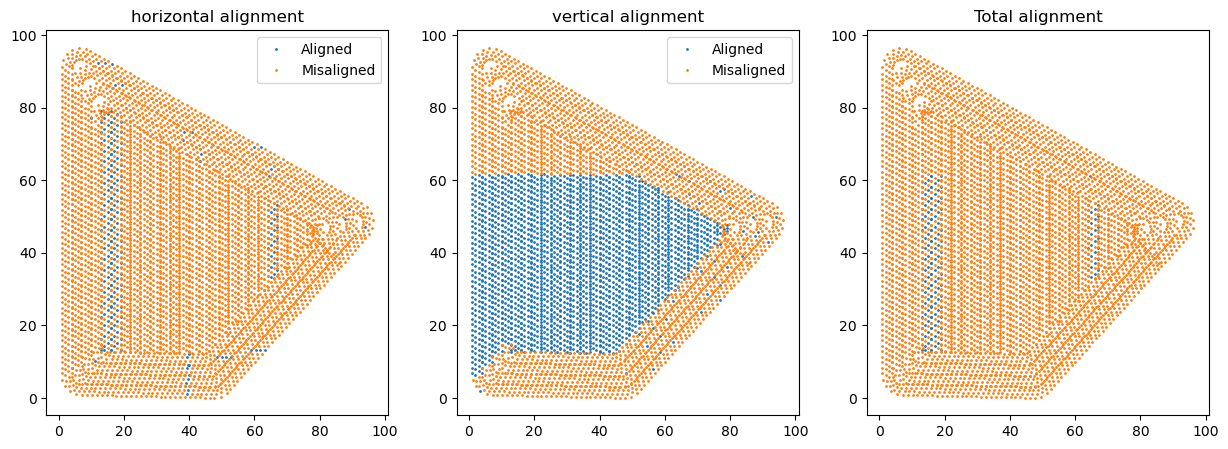

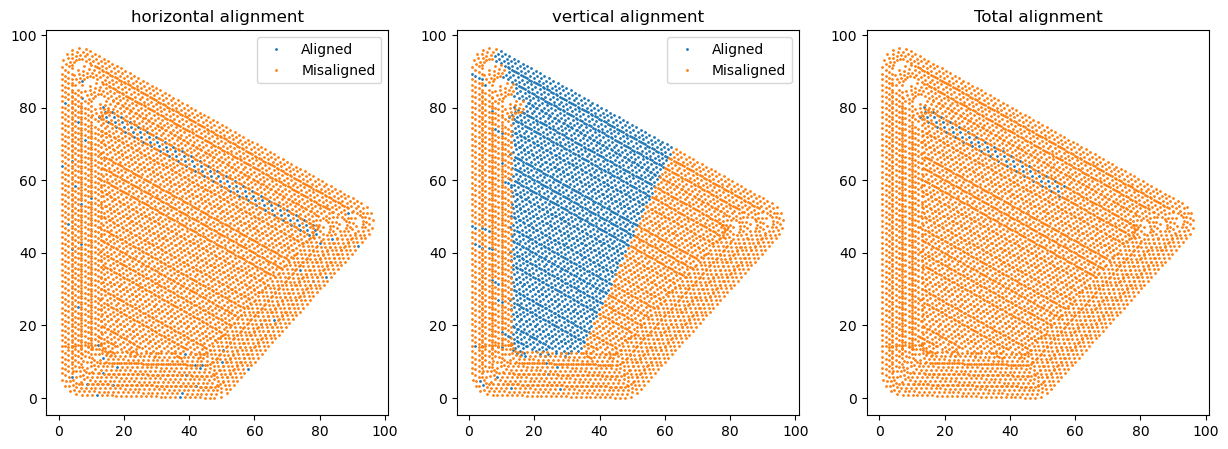

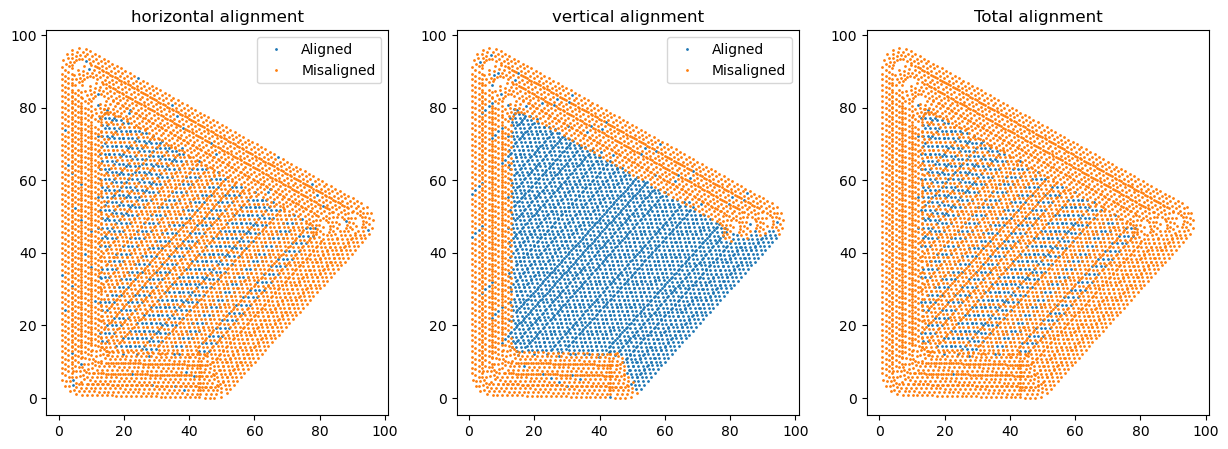

In [227]:
data_path ="./data/field_geometry/test_2.json"
include_obs = False
turning_rad = 4
tractor_width = 3
interpolation_dist = 0.5
seed_distance = 1

field, field_headlands, best_path,sp,swaths_clipped,base, total_path, bases = pathplanning(data_path,include_obs,turning_rad,tractor_width,True,interpolation_dist,seed_distance,False)


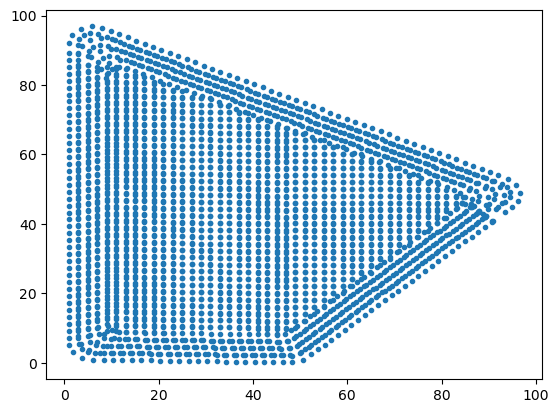

In [179]:
sp_df = gpd.GeoSeries(sp).get_coordinates()
plt.plot(sp_df.x, sp_df.y,'.')

In [207]:
def create_grid(sp,seed_distance,planter_width,interpolation_dist):
    '''
    Creates a grid to evaluate the 'gridness' of the seeds, the grid is based on the first 2 planted rows

    args:
        sp (geopandas.GeoSeries): a geoseries object that contains all seed locations
        seed_distance (float): distance between seeds in a row
        planter_width (float): width of the planter
        interpolation_dist (float): distance between different rows of seeds

    returns:
        grid_hor (MultiLineString): MultiLineString object containing the horizontal lines of the grid
        grid_ver (MultiLineString): MultiLineString object containing the vertical lines of the grid
        seed_count (int): Amount of seeds in one planted row
    '''

    # Create a dataframe of seed coordinates
    sp_df = gpd.GeoSeries(sp).get_coordinates()
    # A list of seed locations one one row of planted seeds (depends on the planter width and seed distance)
    seed_locs = np.arange(0,planter_width,seed_distance)
    seed_count = len(seed_locs)
    print(seed_count)

    # Pick the points of 4 seeds, coming from the first 2 planted rows
    pointa = Point(sp_df.iloc[0])
    pointb = Point(sp_df.iloc[1])
    pointc = Point(sp_df.iloc[seed_count+1])
    pointd = Point(sp_df.iloc[seed_count+2])


    # Creating horizontal and vertical line segments that define the grid
    line_seg_hor = LineString([pointa,pointc])
    line_seg_ver = LineString([pointa,pointb])

    # Calculating field width to scale the line segments
    field_width = max(sp_df['x'])-min(sp_df['x'])
    field_heigth = max(sp_df['y'])-min(sp_df['y'])
    
    # A safety margin to make sure the grid covers the entire field
    safety_marg = 2

    # Scaling a line segment based on field width and a safety margin
    factor = max([field_width,field_heigth])*safety_marg
    line_hor = shapely.affinity.scale(line_seg_hor,xfact = factor,yfact = factor)
    line_ver = shapely.affinity.scale(line_seg_ver,xfact = factor,yfact = factor)

    # Intialize empty lists for the horizontal and vertical lines
    lines_hor = []
    lines_ver = []
    

    # Calculating the nr of lines that are needed for covering the field (taking into account the safety margin)
    nr_lines_hor = int(factor//line_seg_hor.length*safety_marg)
    nr_lines_ver = int(factor//line_seg_ver.length*safety_marg)
    
    # Fill the field based on the required number of lines to form the grid
    for i in range(-nr_lines_hor,nr_lines_hor):
        lines_hor.append(line_hor.parallel_offset(interpolation_dist*i,'left'))
    for i in range(-nr_lines_ver,nr_lines_ver):
        lines_ver.append(line_ver.parallel_offset(1*i,'right'))
    

    # Creating multilinestrings from the grids
    grid_hor = MultiLineString(lines_hor)
    grid_ver = MultiLineString(lines_ver)
    return grid_hor,grid_ver,seed_count

nr of seeds to check: 8080


0.0

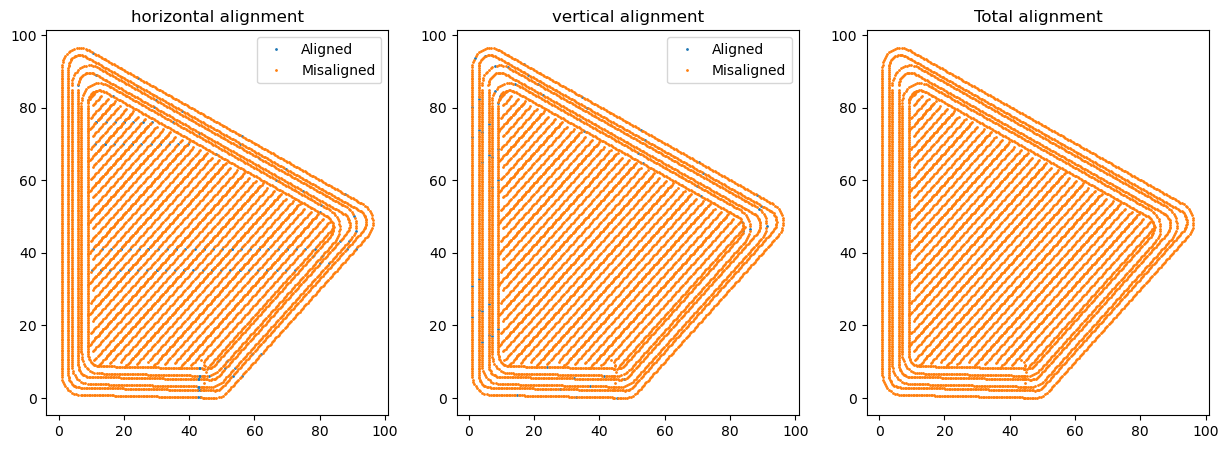

In [208]:
def check_alignment(sp,grid_hor,grid_ver,seed_count,margin = 0.01,full_score = False):
    '''
    Function to check if the seeds are aligned to the grid

    args:
        sp (geopandas.GeoSeries): a geoseries object that contains all seed locations
        grid_hor (MultiLineString): MultiLineString object containing the horizontal lines of the grid
        grid_ver (MultiLineString): MultiLineString object containing the vertical lines of the grid
        seed_count (int): Amount of seeds in one planted row
        margin (float) : accuracy margin for when the seed is considered to be 'on the grid'
        full_score (bool): boolean to indicate whether the accuracy is calculated for all seeds or just 1 seed per row
    returns:
        score (float): a score between 1 and 0 indicating how many seeds are on the grid
    '''

    # If statement to check if we want to calculate all seeds, or just 1 per row
    if full_score:
        index_seeds_to_check = np.arange(0,len(sp.geoms))
    else:
        index_seeds_to_check = np.arange(0,len(sp.geoms),seed_count)
    print('nr of seeds to check: {}'.format(len(index_seeds_to_check)))

    # Creating a list of seeds to check, based on the indices stored in the index list
    seeds_to_check = [seed for index,seed in enumerate(sp.geoms) if index in index_seeds_to_check]

    # Check the alignment for all seeds for horizontal and vertical lines separately
    hor_aligned = [grid_hor.intersects(seed.buffer(margin)) for seed in seeds_to_check]
    ver_aligned = [grid_ver.intersects(seed.buffer(margin)) for seed in seeds_to_check]

    # Result is only true if a seed is on both the vertical and horizontal lies
    results = [hor_aligned[i] and ver_aligned[i] for i in range(len(hor_aligned))]

    # Create a dataframe of the seeds that were checked for plotting purposes
    sp_df = gpd.GeoSeries(sp).get_coordinates().iloc[index_seeds_to_check]
    
    # Store the result in the dataframe for plotting
    sp_df['on_grid_ver'] = hor_aligned
    sp_df['on_grid_hor'] = ver_aligned
    sp_df['on_grid'] = results
    
    
    #Plotting:
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    for (v,c) in [(True,'b'),(False,'r')]:
        ax[0].plot(sp_df.x[sp_df.on_grid_hor == v],sp_df.y[sp_df.on_grid_hor == v],'o',markersize = 1)
    # ax[0].set_xlim([250,620])
    # ax[0].set_ylim([00,600])
    ax[0].legend(['Aligned', 'Misaligned'])
    for (v,c) in [(True,'b'),(False,'r')]:
        ax[1].plot(sp_df.x[sp_df.on_grid_ver == v],sp_df.y[sp_df.on_grid_ver == v],'o',markersize = 1)
    # ax[1].set_xlim([250,620])
    # ax[1].set_ylim([00,600])
    ax[1].legend(['Aligned', 'Misaligned'])
    for (v,c) in [(True,'b'),(False,'r')]:
        ax[2].plot(sp_df.x[sp_df.on_grid == v],sp_df.y[sp_df.on_grid == v],'o',markersize = 1)
    # ax[2].set_xlim([250,620])
    # ax[2].set_ylim([00,600])
    ax[1].legend(['Aligned', 'Misaligned'])

    ax[0].set_title('horizontal alignment')
    ax[1].set_title('vertical alignment')
    ax[2].set_title('Total alignment')
    
    
    score = sum(results)/len(hor_aligned)
    return score

# sp_grid_prep = shapely.prepared.prep(sp)
grid_hor_prepped = shapely.prepared.prep(grid_hor)
grid_ver_prepped = shapely.prepared.prep(grid_ver)
check_alignment(sp,grid_hor_prepped,grid_ver_prepped,seed_count)

C:\Users\20191441\AppData\Local\Temp\ipykernel_7976\689451299.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_lines = pd.concat([edge_lines, pd.DataFrame([[slope, intercept]], columns=['slope', 'intercept'])], ignore_index=True)


No swaths were generated, need to decompose the field.
No swaths were generated, need to decompose the field.
No swaths were generated, need to decompose the field.
No swaths were generated, need to decompose the field.


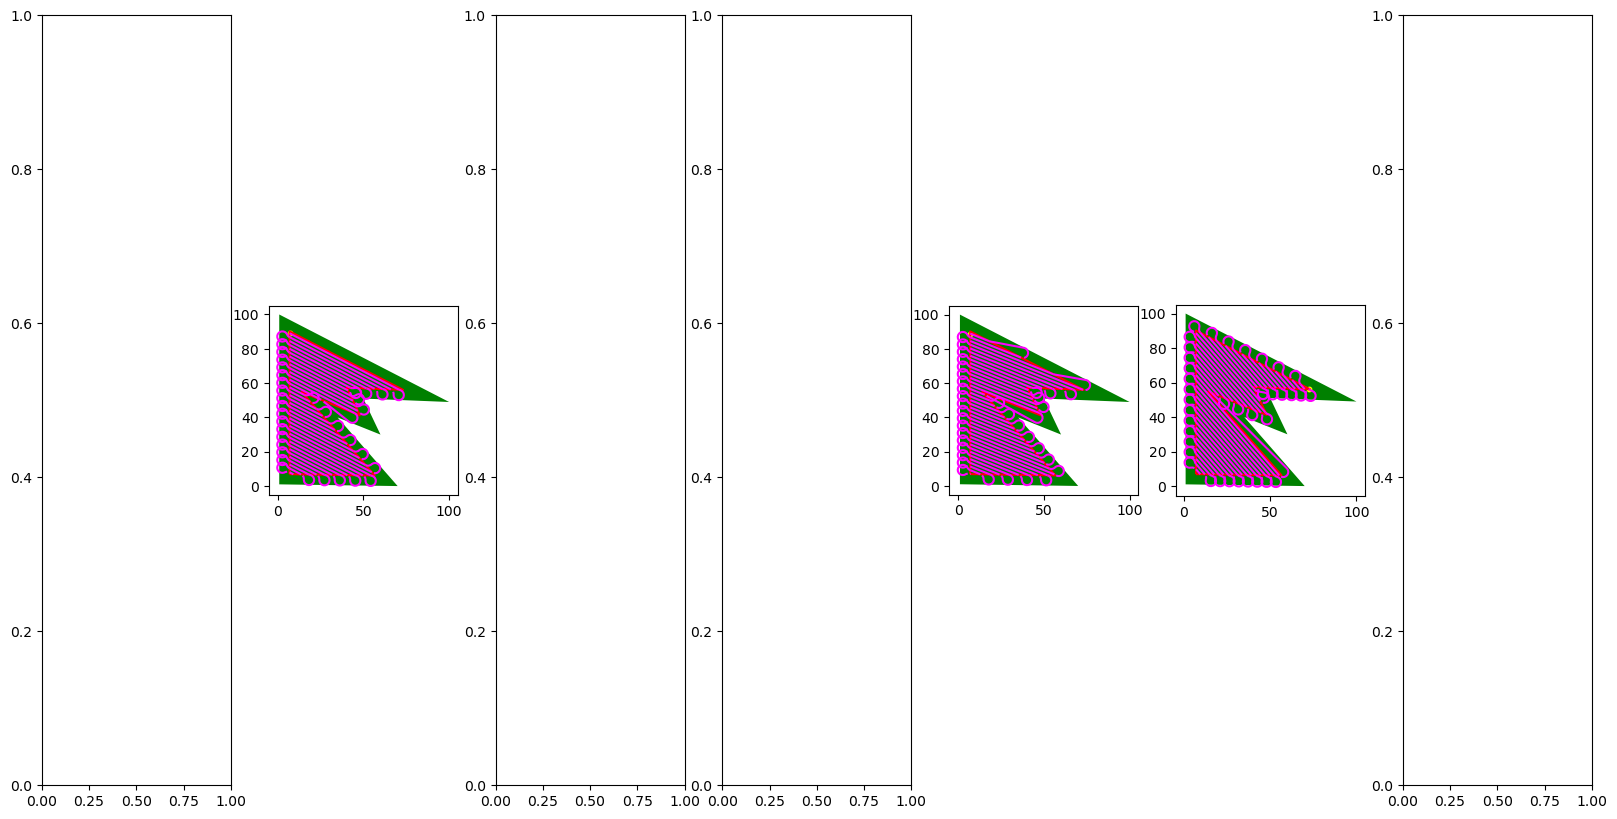

In [ ]:
data_path ="./data/field_geometry/test_4.json"
turn_radius = 3
dist = 2


field = load_data(data_path,include_obs) 
field_headlands = generate_headlands(field,turn_radius)
coordinates = field_headlands.get_coordinates()
lines = edge_to_line(coordinates)


fig, ax = plt.subplots(1, len(coordinates)-1, figsize = (20, 10))

for i in range(len(coordinates)-1): # Loop over all of the edges
    try:
        # Calculate the basis AB line, use that to fill the field and clip the swaths
        line,slope = basis_AB_line(lines.iloc[i],coordinates)
        swath_list = fill_field_AB(line,slope,coordinates,dist)
        swaths_clipped = clip_swaths(swath_list,field_headlands) 
        # Make a path with dubins curves
        path = generate_path(swaths_clipped,turn_radius)
        
        field.plot(ax = ax[i], color = 'green')
        field_headlands.boundary.plot(ax = ax[i],color = 'red')
        ax[i].scatter(path[0][0].coords[0][0], path[0][0].coords[0][1], s=10, color = 'yellow')
  
        for j in range(len(path)):
            path[j].plot(ax = ax[i], color = 'magenta')

    except Exception as error:
        print(error)
   

    

<Axes: >

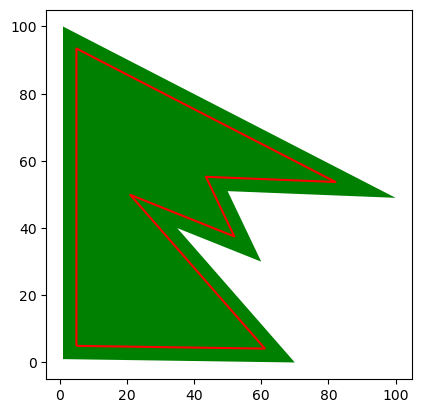

In [ ]:

field = load_data(data_path,include_obs) 

turn_radius = 2
field_headlands = generate_headlands(field,turn_radius)

_, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_headlands.boundary.plot(ax = ax,color = 'red')

In [ ]:
a = LineString([[60,-10],[60,150]])
a_df = gpd.GeoSeries(a)
clipped = gpd.clip(a_df,field)
type(clipped[0])==MultiLineString

True

In [9]:
[ d for d in np.arange(2,2,1)]

[]

In [ ]:
a = LineString([[60,-10],[60,150]])
a_df = gpd.GeoSeries(a)